<a href="https://colab.research.google.com/github/ckgpeace/EIP4/blob/master/Assignment5/AssignmentOther_model/Assignment5_PersonAttrubutes_vanilla14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!kill -9 -1

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=64, shuffle=True, augmentation = None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.resize(cv2.imread(item["image_path"]), (112,112)) for _, item in items.iterrows()])
        #Image Normalization
        if self.augmentation is not None:
          self.augmentation.fit(image)
          image = self.augmentation.flow(image,shuffle=False, batch_size = 64 ).next()
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state = 404)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
10980,resized/10982.jpg,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0
11135,resized/11137.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1
1784,resized/1785.jpg,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0
7758,resized/7759.jpg,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1
4692,resized/4693.jpg,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=64, shuffle=True, 
                                augmentation = ImageDataGenerator(horizontal_flip=True, 
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2,
                                                                  rotation_range=0,
                                                                  zoom_range=0.2,
                                                                  featurewise_center=True, featurewise_std_normalization=True))
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False, augmentation= ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True))

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
inp = Input(shape = (112,112,3))
x = inp

x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='valid')(x) 
x = Activation('relu')(x)
x = BatchNormalization()(x)

### block 1

x = SeparableConv2D(filters=64, kernel_size=(3, 3), padding='valid')(x) 
x = Activation('relu')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=64, kernel_size=(3, 3), padding='valid')(x) 
x = Activation('relu')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=64, kernel_size=(3, 3), padding='valid')(x) 
x = Activation('relu')(x)
x = BatchNormalization()(x)

# Pooling 
x = MaxPooling2D()(x)

# ================================================================

### block

x = SeparableConv2D(filters=128, kernel_size=(3, 3), padding='valid')(x) 
x = Activation('relu')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=128, kernel_size=(3, 3), padding='valid')(x) 
x = Activation('relu')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=128, kernel_size=(3, 3), padding='valid')(x) 
x = Activation('relu')(x)
x = BatchNormalization()(x)


# Pooling 
x = MaxPooling2D()(x)

# ================================================================

### block 2 
x = SeparableConv2D(filters=256, kernel_size=(3, 3), padding='valid')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=256, kernel_size=(3, 3), padding='valid')(x)
x = Activation('relu')(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)


# Pooling 
x = MaxPooling2D()(x)

x = SeparableConv2D(filters=512, kernel_size=(3, 3), padding='valid')(x)
x = Activation('relu')(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(filters=512, kernel_size=(3, 3), padding='valid')(x)
x = Activation('relu')(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)


# Adding Dense layer
def final(in_layer, num_units, class_name, output_name):
  # Conv with class size
  x = SeparableConv2D(filters=num_units[class_name], kernel_size=(1, 1), padding='valid')(in_layer)
  # GAP
  x = GlobalAveragePooling2D()(x)
  x = Activation('softmax', name = output_name)(x)
  return x


gender = final(in_layer = x, num_units = num_units,  class_name = "gender", output_name = "gender_output")
image_quality = final(in_layer = x, num_units = num_units,  class_name = "image_quality", output_name = "image_quality_output")
age = final(in_layer = x, num_units = num_units,  class_name = "age", output_name = "age_output")
weight = final(in_layer = x, num_units = num_units,  class_name = "weight", output_name = "weight_output")
bag = final(in_layer = x, num_units = num_units,  class_name = "bag", output_name = "bag_output")
footwear = final(in_layer = x, num_units = num_units,  class_name = "footwear", output_name = "footwear_output")
emotion = final(in_layer = x, num_units = num_units,  class_name = "emotion", output_name = "emotion_output")
pose = final(in_layer = x, num_units = num_units,  class_name = "pose", output_name = "pose_output")

model = Model(inputs = inp,outputs=[gender, image_quality, age, weight, bag, pose, footwear, emotion])
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
separable_conv2d_418 (Separable (None, 110, 110, 32) 155         input_27[0][0]                   
__________________________________________________________________________________________________
activation_314 (Activation)     (None, 110, 110, 32) 0           separable_conv2d_418[0][0]       
__________________________________________________________________________________________________
batch_normalization_314 (BatchN (None, 110, 110, 32) 128         activation_314[0][0]             
___________________________________________________________________________________________

In [0]:
# from keras.utils import plot_model
# plot_model(model)
import time, psutil
uptime = time.time() - psutil.boot_time()
remain = 12*60*60 - uptime
remain/(60*60)

10.30710022535589

In [0]:
losses = {
	"gender_output": "categorical_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output":  "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy"
}

loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0, "weight_output" :1.0,  "bag_output": 1.0, "pose_output": 1.0,  "footwear_output": 1.0, "emotion_output": 1.0 }



from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

decay_factor =  0.007
def scheduler(epoch, lr):
  return round(lr * 1/(1 + decay_factor * epoch), 10)

opt = SGD(lr = 0.01, momentum=0.9, nesterov=True)

model.compile( optimizer=opt, loss = losses, loss_weights=loss_weights, metrics=["accuracy"])



In [0]:
# model_path = '/content/gdrive/VGG16_vanila_1.h5'
# checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

import os
# Checkpoint saving
save_dir = os.path.join(os.getcwd(), "/gdrive/My\\Drive/saved_models/")
model_name = "model.{epoch:03d}.h5"
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False)

early = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=11, verbose=1, mode='min')

id2label = {1: 'B-LOC', 2: 'I-LOC'}
f1score = F1Metrics(id2label)

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=100,
    verbose=1,
    callbacks=[checkpoint, early, LearningRateScheduler(scheduler, verbose=1), f1score ]
    # callbacks=[checkpoint, early, LearningRateScheduler(scheduler, verbose=1),TensorBoardColabCallback(tbc)]
)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0099999998.
180/180 [==============================] - 118s 654ms/step - loss: 7.9951 - gender_output_loss: 0.6681 - image_quality_output_loss: 0.9877 - age_output_loss: 1.4532 - weight_output_loss: 1.0357 - bag_output_loss: 0.9314 - pose_output_loss: 0.9389 - footwear_output_loss: 1.0136 - emotion_output_loss: 0.9666 - gender_output_acc: 0.5835 - image_quality_output_acc: 0.5489 - age_output_acc: 0.3955 - weight_output_acc: 0.6293 - bag_output_acc: 0.5638 - pose_output_acc: 0.6172 - footwear_output_acc: 0.4995 - emotion_output_acc: 0.7014 - val_loss: 8.2415 - val_gender_output_loss: 0.7063 - val_image_quality_output_loss: 1.1905 - val_age_output_loss: 1.4660 - val_weight_output_loss: 1.0078 - val_bag_output_loss: 1.0347 - val_pose_output_loss: 0.9848 - val_footwear_output_loss: 0.9747 - val_emotion_output_loss: 0.8767 - val_gender_output_acc: 0.6013 - val_image_quality_output_acc: 0.3221 - val_age_output_acc: 0

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0099304864.
180/180 [==============================] - 99s 552ms/step - loss: 7.6836 - gender_output_loss: 0.6431 - image_quality_output_loss: 0.9650 - age_output_loss: 1.4105 - weight_output_loss: 0.9773 - bag_output_loss: 0.8963 - pose_output_loss: 0.9145 - footwear_output_loss: 0.9676 - emotion_output_loss: 0.9094 - gender_output_acc: 0.6256 - image_quality_output_acc: 0.5530 - age_output_acc: 0.3999 - weight_output_acc: 0.6348 - bag_output_acc: 0.5693 - pose_output_acc: 0.6220 - footwear_output_acc: 0.5345 - emotion_output_acc: 0.7078 - val_loss: 8.0260 - val_gender_output_loss: 0.7187 - val_image_quality_output_loss: 1.0730 - val_age_output_loss: 1.4355 - val_weight_output_loss: 0.9792 - val_bag_output_loss: 0.9568 - val_pose_output_loss: 1.0122 - val_footwear_output_loss: 0.9680 - val_emotion_output_loss: 0.8826 - val_gender_output_acc: 0.6129 - val_image_quality_output_acc: 0.5277 - val_age_output_acc: 0.

In [0]:
def evaluate_model(model):
  results = model.evaluate_generator(valid_gen, verbose=1)
  accuracies = {}
  losses = {}
  for k, v in zip(model.metrics_names, results):
    if k.endswith('acc'):
      accuracies[k] = round(v * 100, 4)
    else:
      losses[k] = v
  return accuracies

evaluate_model(model)

# results = model.evaluate_generator(valid_gen, verbose =1)
# dict(zip(model.metrics_names, results))


31/31 [==============================] - 5s 163ms/step


{'age_output_acc': 41.129,
 'bag_output_acc': 66.6835,
 'emotion_output_acc': 72.8831,
 'footwear_output_acc': 58.1653,
 'gender_output_acc': 85.4839,
 'image_quality_output_acc': 44.506,
 'pose_output_acc': 79.9899,
 'weight_output_acc': 64.1129}

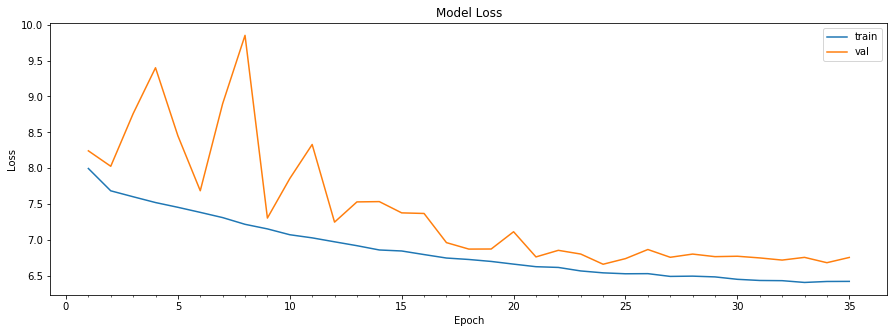

In [0]:
import matplotlib.pyplot as plt
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,1,figsize=(15,5))
    # summarize history for accuracy
    # axs[0].plot(range(1,len(model_history.history.history['acc'])+1),model_history.history['acc'])
    # axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    # axs[0].set_title('Model Accuracy')
    # axs[0].set_ylabel('Accuracy')
    # axs[0].set_xlabel('Epoch')
    # axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    # axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs.plot(range(1,len(model_history.history.history['loss'])+1),model_history.history.history['loss'])
    axs.plot(range(1,len(model_history.history.history['val_loss'])+1),model_history.history.history['val_loss'])
    axs.set_title('Model Loss')
    axs.set_ylabel('Loss')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history.history['loss'])+1),len(model_history.history.history['loss'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.show()
# plot model history
plot_model_history(model)

In [0]:
def scheduler(epoch, lr):
  return round(lr * 1/(1 + decay_factor * epoch), 10)

lr = 0.007
decay_factor = 0.004
epoch = 100
for i in range(epoch):
  lr_new = scheduler(i, lr)
  lr = lr_new
  if i%5 == 0:
    print("the epoch number is: " + str(i) + " and LR is: " + str(round(lr,10)))
  i = i+1

the epoch number is: 0 and LR is: 0.007
the epoch number is: 5 and LR is: 0.0065952219
the epoch number is: 10 and LR is: 0.005634606
the epoch number is: 15 and LR is: 0.0043733703
the epoch number is: 20 and LR is: 0.0030893887
the epoch number is: 25 and LR is: 0.0019897041
the epoch number is: 30 and LR is: 0.0011702877
the epoch number is: 35 and LR is: 0.0006296332
the epoch number is: 40 and LR is: 0.0003103498
the epoch number is: 45 and LR is: 0.0001403585
the epoch number is: 50 and LR is: 5.83287e-05
the epoch number is: 55 and LR is: 2.23045e-05
the epoch number is: 60 and LR is: 7.859e-06
the epoch number is: 65 and LR is: 2.5548e-06
the epoch number is: 70 and LR is: 7.673e-07
the epoch number is: 75 and LR is: 2.132e-07
the epoch number is: 80 and LR is: 5.48e-08
the epoch number is: 85 and LR is: 1.31e-08
the epoch number is: 90 and LR is: 2.9e-09
the epoch number is: 95 and LR is: 6e-10
